In [2]:
import os
import glob
import pandas as pd
import pyarrow

from datetime import datetime

In [12]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

## Read data 

### Blog data EDA

In [4]:
df_blog = pd.read_parquet('../artifacts/data/blog/challenge-blog-00000.snappy.parquet', engine='pyarrow')
df_blog.info()
df_blog.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   language      2726 non-null   object
 1   source        2726 non-null   object
 2   title         2726 non-null   object
 3   url           2726 non-null   object
 4   blog_stats    2726 non-null   object
 5   topimage      2726 non-null   object
 6   domain        2726 non-null   object
 7   author        2308 non-null   object
 8   body          2575 non-null   object
 9   publish_date  2726 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 213.1+ KB


language                                                       en
source                                       minorliteratures.com
title           Thirteen Ways of Looking at a Dead Man — Ben L...
url             https://minorliteratures.com/2023/04/04/thirte...
blog_stats                                                  b'{}'
topimage        https://martymedia.peakm.com/docs/179882/13942...
domain                                       minorliteratures.com
author                                                 yspizzirri
body            This, after all, is what you have paid for to ...
publish_date                                           1680601191
Name: 0, dtype: object

In [46]:
print(datetime.fromtimestamp(max(df_blog.publish_date)))
print(datetime.fromtimestamp(min(df_blog.publish_date)))

2023-05-02 13:13:01
2020-04-17 04:00:32


In [22]:
df_blog.head()

,language,source,title,url,blog_stats,topimage,domain,author,body,publish_date
0,en,minorliteratures.com,Thirteen Ways of Looking at a Dead Man — Ben L...,https://minorliteratures.com/2023/04/04/thirte...,b'{}',https://martymedia.peakm.com/docs/179882/13942...,minorliteratures.com,yspizzirri,"This, after all, is what you have paid for to ...",1680601191
1,en,kingfish1935.blogspot.com,Baking the Bolognese,http://kingfish1935.blogspot.com/2023/03/bakin...,b'{}',https://martymedia.peakm.com/docs/149503/13942...,kingfish1935.blogspot.com,Posted by\nKingfish,Marshand Crisler will be the honorary referee ...,1680264000
2,en,logosofindia.blogspot.com,THE HUTTI GOLD MINES COMPANY LIMITED,https://logosofindia.blogspot.com/2023/03/the-...,b'{}',https://martymedia.peakm.com/docs/1871409/1394...,logosofindia.blogspot.com,Design Thinker,The industry subsequently declined and eventua...,1680325807
3,en,news.alaskaair.com,Alaska Airlines and Surfrider Foundation partn...,https://news.alaskaair.com/alaska-airlines/ala...,b'{}',https://martymedia.peakm.com/docs/1687180/1394...,news.alaskaair.com,Alaska Airlines,Photos courtesy of The Surfrider Foundation. d...,1680632780
4,en,Medium,Stop The Innovation Theatre with Steve Blank -...,https://medium.com/@Defense_Unicorns/stop-the-...,"b'{""geo_domain"":{""countryCode"":""US"",""stateCode...",https://martymedia.peakm.com/https://miro.medi...,medium.com,Defense Unicorns,12) Hacking for Defense(7 35) Connecting civil...,1680538586


In [27]:
df_blog.author.value_counts().nlargest(20)

author
Blue                             59
drbyos                           48
General Aviation News Staff      24
Posted by\nKingfish              18
Unknown Author                   16
admin                            15
Unknown                          15
Holier Than Tao                  15
par François Duclos              14
Origami guide tv                 13
par Thierry Blancmont            12
nsebulltrades                    11
Location                         11
The Millennial Press             11
richardsteventhomas              10
Orkidie                          10
Zero Hedge                       10
tinku89                           9
rickeysmileymorningshow Staff     9
chintanvibgmailcom                9
Name: count, dtype: int64

In [35]:
print("title:", df_blog[df_blog.author == 'General Aviation News Staff'].iloc[1]['title'], "\n")
print("body:", df_blog[df_blog.author == 'General Aviation News Staff'].iloc[1]['body'][:500], "\n")
print("date:", datetime.fromtimestamp(df_blog[df_blog.author == 'General Aviation News Staff'].iloc[1]['publish_date']))

title: 10 tips for a successful introductory flight — General Aviation ... 

body: But you also must be clear that once airborne, if they decide they'd rather be on the ground, you can't just pull over and let them out. Emphasize that safety is the first priority, so if they want to cut the flight short, you'll move as quickly as possible to return them to the ground. 2. Get them involved If the chance presents itself, have the passenger help with the pre-flight walkaround inspection. Answer questions without overexplaining anything. Pilots have forgotten more about aviation t 

date: 2023-04-20 12:20:16


Note: Blog data doesn't seem very relevant. It includes variety of topics about very general matters, and may not be very helpful to extract airline based information. Maybe a keyword based search may be tried later to extract airline articles only. 

In [5]:
df_blog = df_blog[(df_blog['body'].str.len() > 30) & 
                        (df_blog.language == 'en') &
                        (df_blog.body.notna())].reset_index()
df_blog['text_clean'] = df_blog['body'].apply(lambda x: x.lower())

In [9]:
df_blog_UNITED = df_blog[df_blog['text_clean'].str.contains("united airlines")]
blog_united_list = df_blog_UNITED['text_clean'].tolist()   

In [13]:
vectorizer_model = CountVectorizer(stop_words="english")
blog_united_model = BERTopic(
    vectorizer_model=vectorizer_model, 
    language='english', 
    calculate_probabilities=True,
    verbose=True)

blog_topics, blog_probs = blog_united_model.fit_transform(blog_united_list)

Batches: 100%|████████████████████████████████████| 3/3 [00:14<00:00,  4.96s/it]
2023-05-25 16:37:43,869 - BERTopic - Transformed documents to Embeddings
2023-05-25 16:37:54,437 - BERTopic - Reduced dimensionality
2023-05-25 16:37:54,497 - BERTopic - Clustered reduced embeddings


In [16]:
freq = blog_united_model.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,22,-1_https_people_dina_john
1,0,40,0_airlines_travel_flights_united
2,1,29,1_people_did_state_new


In [47]:
blog_united_model.get_topic(0)

[('airlines', 0.04929799195848685),
 ('travel', 0.030020346513062804),
 ('flights', 0.02891109305145797),
 ('united', 0.026976133374042442),
 ('airport', 0.026619727854239234),
 ('new', 0.0240802390841406),
 ('flight', 0.023014450417475033),
 ('hotel', 0.021143851095560495),
 ('service', 0.018973305586328915),
 ('time', 0.018663394329910474)]

In [21]:
topic_summary = blog_united_model.get_document_info(blog_united_list)
topic_summary.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,"the colors represent the blue sky, crystal cle...",0,0_airlines_travel_flights_united,airlines - travel - flights - united - airport...,0.457223,False
1,united airlines makes second investment in car...,0,0_airlines_travel_flights_united,airlines - travel - flights - united - airport...,0.706083,False
2,"as the saying says, good parents produce good ...",1,1_people_did_state_new,people - did - state - new - dont - time - lik...,0.682146,False
3,"other days, body weight exercise reverse lunge...",-1,-1_https_people_dina_john,https - people - dina - john - world - time - ...,0.359710,True
4,here are some other notable premarket movers b...,-1,-1_https_people_dina_john,https - people - dina - john - world - time - ...,0.491505,False


### News data EDA

In [23]:
path = '../artifacts/data/news/'
parquet_files = glob.glob(os.path.join(path, "*.parquet"))
  
  
# loop over the list of csv files
for i, f in enumerate(parquet_files):
      
    # read the csv file
    df_temp = pd.read_parquet(f)
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
    if i == 0:
        df_news = df_temp
    else:
        df_news = pd.concat([df_news, df_temp])    

df_news.info()

File Name: ../artifacts/data/news/challenge-news-00001.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00009.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00006.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00013.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00012.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00007.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00008.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00000.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00002.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00010.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00005.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00004.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00011.snappy.parquet
File Name: ../artifacts/data/news/challenge-news-00003.snappy.parquet
<class 'pandas.core.

In [24]:
print(datetime.fromtimestamp(max(df_news.publish_date)))
print(datetime.fromtimestamp(min(df_news[df_news.publish_date > 0].publish_date)))

2023-05-02 13:13:56
2005-05-14 17:00:00


In [307]:
df_news.iloc[0]

language                                                           en
source                                                       Swarajya
headline            Air India Takes Major Digital Transformation I...
url                 https://swarajyamag.com/business/air-india-tak...
news_stats          b'{"geo_domain":{"countryCode":"IN","stateCode...
topimage            https://martymedia.peakm.com/docs/7173/1419301...
summary                                                          None
domain                                                swarajyamag.com
journalist                                             Swarajya Staff
body                Air India has updated its digital systems and ...
publish_date                                               1682413370
socialcount_last                                                  NaN
Name: 0, dtype: object

In [308]:
df_news.language.value_counts().nlargest(10)

language
en       95741
es       26487
de        1889
ru        1340
fr        1225
pt         619
it         488
el         475
en-us      471
tr         469
Name: count, dtype: int64

In [310]:
df_news.domain.value_counts().nlargest(10)

domain
lahinchada.com.pe         1939
msn.com                   1489
news.yahoo.com             924
mdpi.com                   914
forpost-sevastopol.ru      899
segurb2b.com               746
simpleflying.com           641
thestockmarketnews.com     534
aol.com                    516
marketbeat.com             486
Name: count, dtype: int64

In [512]:
df_news.iloc[0].body

'Air India has updated its digital systems and will soon introduce a ChatGPT-powered chatbot, investing 200 million in modernisation efforts The airline has made significant advancement in modernising its digital systems and has completed many initiatives, with several others close to being finished Air India has also invested in creating a digital and technology team with presence in Kochi, Gurugram, and Silicon Valley (US), as they invest in the latest technology. The airline stated all group airlines, including low-cost carriers, will benefit from technological modernisation of digital infrastructure, reported the Financial Express Common systems will be implemented across all group airlines to benefit from economies-of-scale and economies-of-learning, the result of which will be driven by shared platforms and a world-class team The airline stated they invested around 200 million in digital systems, engineering services, and workforce development, aiming to be a leading player in th

In [248]:
df_news.iloc[0].headline

'Air India Takes Major Digital Transformation Initiative With Investments Worth $200 Million, To Introduce ChatGPT-powered Chatbot'

In [516]:
df_news_clean_headline = df_news[df_news.headline.notna()]
df_news_clean_headline['headline_lower'] = df_news_clean_headline['headline'].apply(lambda x: x.lower())

In [517]:
df_news_clean_headline['headline_lower'].iloc[0]

'air india takes major digital transformation initiative with investments worth $200 million, to introduce chatgpt-powered chatbot'

#### News data Topic model 

In [25]:
df_news = df_news[(df_news['body'].str.len() > 30) & 
                        (df_news.language == 'en') &
                        (df_news.body.notna())].reset_index()
df_news['text_clean'] = df_news['body'].apply(lambda x: x.lower())

In [26]:
df_news_UNITED = df_news[df_news['text_clean'].str.contains("united airlines")]
news_united_list = df_news_UNITED['text_clean'].tolist()   

In [27]:
vectorizer_model = CountVectorizer(stop_words="english")
news_united_model = BERTopic(
    vectorizer_model=vectorizer_model, 
    language='english', 
    calculate_probabilities=True,
    verbose=True)

news_topics, news_probs = news_united_model.fit_transform(news_united_list)

Batches: 100%|████████████████████████████████| 105/105 [08:30<00:00,  4.86s/it]
2023-05-25 21:00:32,459 - BERTopic - Transformed documents to Embeddings
2023-05-25 21:01:06,757 - BERTopic - Reduced dimensionality
2023-05-25 21:01:08,717 - BERTopic - Clustered reduced embeddings


In [49]:
freq = news_united_model.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,658,-1_airlines_united_said_year
1,0,92,0_zealand_brisbane_san_flights
2,1,72,1_flight_airport_plane_window
3,2,70,2_etf_shares_fund_ishares
4,3,67,3_bass_mess_clean_attendant
5,4,61,4_rewards_points_card_earn
6,5,61,5_stock_shares_rating_ual
7,6,60,6_innovation_carbon_maryanne_electric
8,7,54,7_flights_summer_united_destinations
9,8,52,8_investigation_start_crime_google


In [57]:
news_united_model.get_topic(0)

[('zealand', 0.04954083985040113),
 ('brisbane', 0.04485400413122711),
 ('san', 0.042305669913760974),
 ('flights', 0.042240397316060795),
 ('australia', 0.04084039614412917),
 ('francisco', 0.04054365044461157),
 ('united', 0.03794599069368532),
 ('los', 0.028361212830608516),
 ('service', 0.028181596598815143),
 ('auckland', 0.027664109109388157)]

In [33]:
news_united_model.get_topic(3)

[('bass', 0.08518508604894731),
 ('mess', 0.06287181907471383),
 ('clean', 0.05960301916606696),
 ('attendant', 0.05819763866762376),
 ('wife', 0.05777476288373037),
 ('popcorn', 0.0533750835411839),
 ('pregnant', 0.0494793054659657),
 ('anthony', 0.048802109558858164),
 ('flight', 0.04221185660044586),
 ('old', 0.040809313524107195)]

In [43]:
topic_summary = news_united_model.get_document_info(news_united_list)

In [44]:
topic_summary[topic_summary.Topic == 3].head(3)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
33,"traveling by aeroplane is never simple, especi...",3,3_bass_mess_clean_attendant,bass - mess - clean - attendant - wife - popco...,0.380107,False
170,a feud between united airlines crew and baseba...,3,3_bass_mess_clean_attendant,bass - mess - clean - attendant - wife - popco...,1.000000,False
270,hotels have worked to keep their covid protoco...,3,3_bass_mess_clean_attendant,bass - mess - clean - attendant - wife - popco...,0.725137,False


In [45]:
topic_summary[topic_summary.index == 170].iloc[0]['Document']

'a feud between united airlines crew and baseball player anthony bass went viral after the man tweeted out that a flight attendant "made his pregnant wife get on her knees to pick up the popcorn mess made by his youngest daughter." anthony bass made a tweet on april 16 where he shared his displeasure with how united airlines treated his wife traveling with their children. in the tweet, he wrote "the flight attendant @united just made my 22-week pregnant wife traveling with a 5-year-old and 2-year-old get on her hands and knees to pick up the popcorn mess by my youngest daughter. are you kidding me?!?!"article continues after ad the pitcher immediately sparked a fierce debate among the users of twitter as to whether the flight attendant was in the right to make a pregnant woman do such a thing. baseball pitcher anthony bass\' united airlines tweet roasted some of the replies to the tweet side with anthony, stating that cleaning the cabin is part of the job of the staff hired by the airl

### Social data EDA

In [59]:
path = '../artifacts/data/social/'
parquet_files = glob.glob(os.path.join(path, "*.parquet"))
  
  
# loop over the list of csv files
for i, f in enumerate(parquet_files):
      
    # read the csv file
    df_temp = pd.read_parquet(f)
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
    if i == 0:
        df_social = df_temp
    else:
        df_social = pd.concat([df_social, df_temp])    

df_social.reset_index(drop=True, inplace=True)
df_social.info()

File Name: ../artifacts/data/social/challenge-social-00007.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00000.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00008.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00001.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00006.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00004.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00003.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00002.snappy.parquet
File Name: ../artifacts/data/social/challenge-social-00005.snappy.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85665 entries, 0 to 85664
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   language          85665 non-null  object 
 1   source            85665 non-null  object 
 2   title             85665 non-null

In [306]:
df_social.domain.value_counts()

domain
twitter.com    59145
reddit.com     20672
youtu.be        5471
tiktok.com       377
Name: count, dtype: int64

In [251]:
print(datetime.fromtimestamp(max(df_social.publish_date)))
print(datetime.fromtimestamp(min(df_social[df_social.publish_date > 0].publish_date)))

2023-04-30 16:37:28
2010-01-14 11:44:35


In [302]:
df_social.iloc[30]

language                                                           en
source                                             Netsyrk_ - Twitter
title               RT @alexiatyannax3: Honestly… the airline indu...
url                 https://twitter.com/Netsyrk_/status/1649956182...
social_stats                               b'{"audience_visits":757}'
socialcount_last                                                  1.0
domain                                                    twitter.com
account                                                      Netsyrk_
text                RT @alexiatyannax3: Honestly… the airline indu...
publish_date                                             1682215183.0
user                b'{"followers":757,"screen_name":"Netsyrk_","n...
topimage                                                             
Name: 30, dtype: object

In [304]:
df_social.iloc[30].title

'RT @alexiatyannax3: Honestly… the airline industry needs to get regulated bc there’s way too many issues for the continuous increase in pri…'

In [305]:
df_social.iloc[30].text

"RT @alexiatyannax3: Honestly… the airline industry needs to get regulated bc there's way too many issues for the continuous increase in pri… "

#### Cleaning tweets - social media entries

In [62]:
import re

In [388]:
import string
from nltk.corpus import stopwords
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [60]:
# def remove_punct(text):
#     text  = "".join([char for char in text if char not in string.punctuation])
#     text = re.sub('[0-9]+', '', text)
#     return text

def clean_tweet(tweet):
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    # temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [63]:
df_social_clean = df_social[(df_social.language == 'en') & (df_social.text.notna())]
df_social_clean['text_clean'] = df_social_clean['text'].apply(lambda x: clean_tweet(x))

In [354]:
df_social_clean[['text', 'text_clean']].head(10)

,text,text_clean
0,Great \nWhat are you waiting for ????\nGet on ...,great what are you waiting for get on the next...
1,An American Airlines flight encountered an ala...,an american airlines flight encountered an ala...
2,@JeremyVineOn5 I wonder what airline they will...,i wonder what airline they will use to send th...
3,"China Airlines flight #CAL023 spotted at 6,000...",china airlines flight spotted at 6 000 feet
4,\n\nBreeze Airways is a new low-cost airline ...,breeze airways is a new low cost airline based...
5,(Insider):#American Airlines plane forced to r...,insider airlines plane forced to return to ohi...
6,"United Airlines flight #UAL412 spotted at 37,0...",united airlines flight spotted at 37 025 feet
7,#KOMA - #UAL289 (737-9 ) United Airlines @ 330...,737 9 united airlines 33000 ft and 50 0 frm hr...
8,➠United Airlines (Star Alliance livery) Boeing...,united airlines star alliance livery boeing 76...
9,RT @alvinfoo: China's luxurious high speed tra...,rt chinas luxurious high speed train i have ta...


In [321]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

### Social Topic modeling

In [107]:
df_social_sample = df_social_clean.sample(n=20000, random_state=1)
social_texts_sample = df_social_sample['text_clean'].tolist()
social_texts_sample[0]

'oddly enough there was a big story yesterday about how the pregnant spouse of a toronto blue jays player was forced by the flight attendant to pick up popcorn after her two kids on a flight and the toronto blue jays player scolded the airline on twitter'

##### Wordcloud Analysis

In [393]:
social_SAMPLE = " ".join(review for review in df_social_sample['text_clean'])

(-0.5, 399.5, 199.5, -0.5)

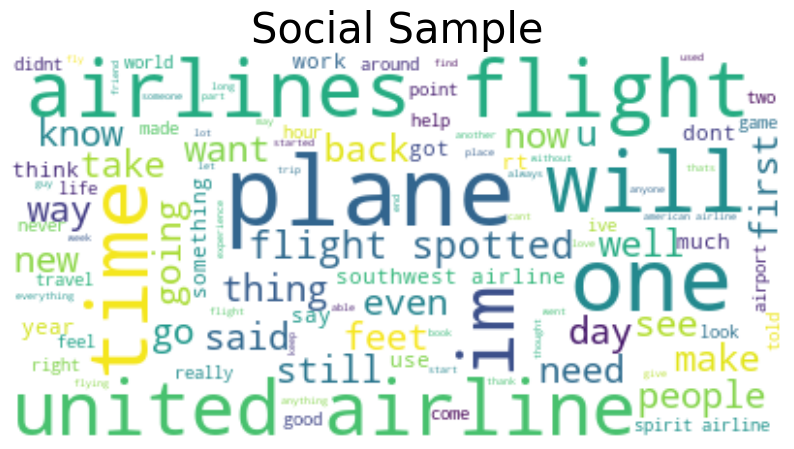

In [397]:
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_social_SAMPLE = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(social_SAMPLE)
# Display the generated image:
ax.imshow(wordcloud_social_SAMPLE, interpolation='bilinear')
ax.set_title('Social Sample', fontsize=30)
ax.axis('off')

##### Topic/Sentiment analysis to only "United" socials 

In [64]:
df_social_UNITED = df_social_clean[df_social_clean['text_clean'].str.contains("united airlines")]
df_social_UNITED.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11677 entries, 6 to 85650
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   language          11677 non-null  object 
 1   source            11677 non-null  object 
 2   title             11677 non-null  object 
 3   url               11677 non-null  object 
 4   social_stats      11677 non-null  object 
 5   socialcount_last  10951 non-null  float64
 6   domain            11677 non-null  object 
 7   account           11677 non-null  object 
 8   text              11677 non-null  object 
 9   publish_date      11660 non-null  float64
 10  user              11390 non-null  object 
 11  topimage          11677 non-null  object 
 12  text_clean        11677 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.2+ MB


In [65]:
vectorizer_model = CountVectorizer(stop_words="english")
social_united_model = BERTopic(
    vectorizer_model=vectorizer_model, 
    language='english', 
    calculate_probabilities=True,
    verbose=True)

social_united_list = df_social_UNITED['text_clean'].tolist()
topics, probs = social_united_model.fit_transform(social_united_list)

Batches: 100%|████████████████████████████████| 365/365 [03:06<00:00,  1.96it/s]
2023-05-26 13:22:45,866 - BERTopic - Transformed documents to Embeddings
2023-05-26 13:23:25,961 - BERTopic - Reduced dimensionality
2023-05-26 13:24:54,471 - BERTopic - Clustered reduced embeddings


In [457]:
for i in range(5):
    print(f"{topics[i]}: {social_united_list[i]}")

246: united airlines flight spotted at 37 025 feet
114: 737 9 united airlines 33000 ft and 50 0 frm hrzn heading e 01 54 52
298: united airlines star alliance livery boeing 767 322 er 8mls sw of havant 16500ft heading ne at 340mph reg n653ua cs ual14 sq 7647 ryanair boeing 737 8as 16mls se of havant 35000ft heading sse at 451mph reg ei dlw cs ryr89ch sq 0520 24 04 2023 09 00 37
304: united airlines flight spotted at 22 350 feet
3: a320 232 a320 united airlines 30000 ft and 61 6 frm hrzn heading e 22 47 25


In [104]:
freq = social_united_model.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,2144,-1_ng_nh_th_ch
1,0,193,0_bass_anthony_jays_wife
2,1,160,1_a319_131_132_frm
3,2,111,2_summer_routes_international_expands
4,3,103,3_ual_holdings_earnings_est
5,4,99,4_a320_232_hrzn_frm
6,5,99,5_communications_group_pilotos_correctly
7,6,98,6_login_airlinesunited_discounts_171
8,7,98,7_pitcher_clean_jays_pregnant
9,8,94,8_kids_clean_children_child


In [69]:
social_united_model.get_topic(0)

[('bass', 0.06993346832205083),
 ('anthony', 0.06326728946766437),
 ('jays', 0.04427097341383608),
 ('wife', 0.04021253927172487),
 ('blue', 0.039761178060389354),
 ('pitcher', 0.03676728628839782),
 ('toronto', 0.03147126137972494),
 ('clean', 0.03048844090672312),
 ('pregnant', 0.028385022510954514),
 ('kids', 0.02504785161655071)]

In [79]:
social_united_model.get_topic(2)

[('summer', 0.07317184799899752),
 ('routes', 0.038936112953070263),
 ('international', 0.033676965409019224),
 ('expands', 0.033056187436821954),
 ('schedule', 0.03211982153665603),
 ('destinations', 0.03150844386023454),
 ('flights', 0.028591157606329198),
 ('cities', 0.028163455953231966),
 ('atlantic', 0.027093094357468556),
 ('adding', 0.026765897601592335)]

In [80]:
social_united_model.get_topic(3)

[('ual', 0.09080112551856617),
 ('holdings', 0.05681225685909591),
 ('earnings', 0.047209997927977934),
 ('est', 0.04062541163581134),
 ('43b', 0.03955932246585522),
 ('q1', 0.036306390491311666),
 ('financial', 0.03556047009523503),
 ('eps', 0.03484525967440788),
 ('nasdaq', 0.030779438259594567),
 ('revenue', 0.028343695428427268)]

In [101]:
topic_summary = social_united_model.get_document_info(social_united_list)
topic_summary[topic_summary.Topic == 0].head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
39,blue jays anthony bass slams united airlines,0,0_bass_anthony_jays_wife,bass - anthony - jays - wife - blue - pitcher ...,1.000000,False
564,parenting in 2021 blue jays anthony bass slams...,0,0_bass_anthony_jays_wife,bass - anthony - jays - wife - blue - pitcher ...,0.749912,False
566,rt toronto blue jays pitcher anthony bass is s...,0,0_bass_anthony_jays_wife,bass - anthony - jays - wife - blue - pitcher ...,0.165030,False
567,blue jays anthony bass slams united airlines f...,0,0_bass_anthony_jays_wife,bass - anthony - jays - wife - blue - pitcher ...,0.384264,False
571,a united airlines flight attendant allegedly f...,0,0_bass_anthony_jays_wife,bass - anthony - jays - wife - blue - pitcher ...,0.302501,False


In [86]:
topic_summary[topic_summary.Topic == 0].Document.iloc[3]

'blue jays anthony bass slams united airlines for making pregnant wife clean kids messes on hands and knees'

In [103]:
topic_summary[topic_summary.Topic == 0].Document.iloc[4]

'a united airlines flight attendant allegedly forced the 22 week pregnant wife of toronto blue jays pitcher anthony bass to clean the planes cabin on her hands and knees'

In [88]:
topic_summary[topic_summary.Topic == 2].Document.iloc[1]

'united airlines will fly to 114 different international cities this summer and has expanded its flying by 25 versus last year'

In [98]:
topic_summary[topic_summary.Topic == 3].Document.iloc[21]

'united airlines stock chart fibonacci analysis 042923 trading idea entry point 44 61 80'

##### Topic modeling analysis to whole sample 

In [108]:
vectorizer_model = CountVectorizer(stop_words="english")
social_sample_model = BERTopic(
    vectorizer_model=vectorizer_model, 
    language='english', 
    calculate_probabilities=True,
    verbose=True)

topics, probs = social_sample_model.fit_transform(social_texts_sample)

Batches: 100%|████████████████████████████████| 625/625 [12:46<00:00,  1.23s/it]
2023-05-26 15:00:40,126 - BERTopic - Transformed documents to Embeddings
2023-05-26 15:01:01,136 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-26 15:04:54,595 - BERTopic - Clustered reduced embeddings


In [111]:
for i in range(5):
    print(f"{topics[i]}: {social_texts_sample[i]}")

77: oddly enough there was a big story yesterday about how the pregnant spouse of a toronto blue jays player was forced by the flight attendant to pick up popcorn after her two kids on a flight and the toronto blue jays player scolded the airline on twitter
-1: i am trying to find an old friend of my grandmothers whose contact information she lost decades ago the friend is named leo he was from the netherlands but lived in detroit michigan for a period of time working as a head chef at a restaurant possibly michelin star my grandmother colleen an american met leo on a plane to the netherlands in 1962 she didnt have accommodation plans so leo invited her to stay with his family in s hertogenbosch she stayed with them for a month she remembers his mothers cooking and biking to leos uncles farm leo possibly had a twin brother but my grandmother is not sure that is correct she does not quite remember what leo looked like but says he had a great personality any leads would be greatly apprec

In [110]:
freq = social_sample_model.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,6852,-1_ng_plane_airline_nh
1,0,401,0_delta_feet_spotted_flight
2,1,382,1_spirit_airlines_ghosts_fly
3,2,340,2_told_didnt_relationship_friends
4,3,313,3_spirit_feet_spotted_flight
5,4,283,4_level_body_astral_world
6,5,264,5_united_airlines_rt_express
7,6,256,6_airline_airways_cambrian_ser
8,7,229,7_delta_deltas_customer_service
9,8,200,8_southwest_airlines_texas_hsr


In [230]:
social_sample_model.get_topic(7)

[('delta', 0.0936722479712925),
 ('deltas', 0.023920515464044147),
 ('customer', 0.01671281097848389),
 ('service', 0.012589097178904348),
 ('book', 0.012288369143513337),
 ('booking', 0.012153269979377232),
 ('lines', 0.011798737696350863),
 ('airlines', 0.01032338025151275),
 ('offers', 0.009779246237443782),
 ('reservation', 0.009517391824111586)]

In [200]:
social_topic_summary = social_sample_model.get_document_info(social_texts_sample)
social_topic_summary[(social_topic_summary.Topic == 1) & 
                     (social_topic_summary.Representative_document == True)].head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
2471,spirit airlines,1,1_spirit_airlines_ghosts_fly,spirit - airlines - ghosts - fly - finds - cle...,0.294797,True
3099,spirit airlines,1,1_spirit_airlines_ghosts_fly,spirit - airlines - ghosts - fly - finds - cle...,0.486419,True
5298,spirit airlines,1,1_spirit_airlines_ghosts_fly,spirit - airlines - ghosts - fly - finds - cle...,0.340045,True
6886,spirit airlines again,1,1_spirit_airlines_ghosts_fly,spirit - airlines - ghosts - fly - finds - cle...,0.214727,True
7382,spirit airlines,1,1_spirit_airlines_ghosts_fly,spirit - airlines - ghosts - fly - finds - cle...,1.000000,True


In [229]:
social_topic_summary[social_topic_summary.Topic == 7].Document.iloc[22]

'daily reminder if you fly on delta airlines youre doing so at great risk my recommendation if youre planning a trip use another airline youll thank me later if you cant book with another airline just walk youll arrive at your destination sooner much safer'

In [208]:
social_topic_summary[social_topic_summary.Topic == 9].Document.iloc[6]

'a fat tiktoker is demanding that the faa protect plus size travelers by providing obese people with free airplane seats hit the obese tiktoker wants free airline seats for fatties s1 e66'

### News Topic modeling

In [140]:
df_news_clean = df_news[(df_news['body'].str.len() > 30) & 
                        (df_news.language == 'en') &
                        (df_news.headline.notna())].reset_index()

In [141]:
# we add this to remove stopwords, for lower volumes of data stopwords can cause issues
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

news_sample_list = df_news_clean.iloc[:10000,:]['headline'].tolist()

In [142]:
# model = BERTopic(
#     vectorizer_model=vectorizer_model,
#     language='english', calculate_probabilities=True,
#     verbose=True
# )
model_new = BERTopic()
topics, probs = model_new.fit_transform(news_sample_list)

2023-05-26 15:18:53,412 - BERTopic - Transformed documents to Embeddings
2023-05-26 15:19:10,690 - BERTopic - Reduced dimensionality
2023-05-26 15:19:11,413 - BERTopic - Clustered reduced embeddings


In [143]:
for i in range(5):
    print(f"{topics[i]}: {df_news_clean.iloc[:10000,:]['headline'][i]}")

-1: Air India Takes Major Digital Transformation Initiative With Investments Worth $200 Million, To Introduce ChatGPT-powered Chatbot
203: US rapper Desiigner charged after masturbating on flight
20: Chad denies supporting any warring factions in Sudan conflict
-1: Democrat Congressman From New York Has Made 500 Stock Trades Since Taking Office in January | The Gateway  ...
-1: AKK Gas Pipeline Project Nears 70% Completion – NNPCL


In [144]:
freq = model_new.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,3868,-1_the_to_and_on
1,0,120,0_stocks_stock_gains_inflation
2,1,114,1_ukraine_war_russia_russiaukraine
3,2,112,2_her_christina_aguilera_wife
4,3,102,3_sudan_citizens_diplomats_evacuations
5,4,99,4_southwest_nationwide_issues_ground
6,5,87,5_india_air_indias_pilots
7,6,81,6_emirates_dubai_qatar_saudi
8,7,77,7_obituary_remembers_legacy_dies
9,8,74,8_llc_shares_holdings_position


In [209]:
model_new.get_topic(4)

[('southwest', 0.12072159005261891),
 ('nationwide', 0.08044092399180783),
 ('issues', 0.04687654498477673),
 ('ground', 0.04624317443129873),
 ('flights', 0.04202389487052187),
 ('stop', 0.03797540129971068),
 ('due', 0.036337733912668424),
 ('airlines', 0.03630726713446746),
 ('technical', 0.035852844464886326),
 ('grounded', 0.03481811173849516)]

In [147]:
topic_summary = model_new.get_document_info(news_sample_list)
topic_summary.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,Air India Takes Major Digital Transformation I...,-1,-1_the_to_and_on,the - to - and - on - for - in - of - with - i...,0.000000,False
1,US rapper Desiigner charged after masturbating...,203,203_desiigner_charged_rapper_indecent,desiigner - charged - rapper - indecent - expo...,1.000000,False
2,Chad denies supporting any warring factions in...,20,20_truce_khartoum_ceasefire_sudan,truce - khartoum - ceasefire - sudan - despite...,0.644636,False
3,Democrat Congressman From New York Has Made 50...,-1,-1_the_to_and_on,the - to - and - on - for - in - of - with - i...,0.000000,False
4,AKK Gas Pipeline Project Nears 70% Completion ...,-1,-1_the_to_and_on,the - to - and - on - for - in - of - with - i...,0.000000,False


In [159]:
topic_summary[topic_summary.Topic == 4].Document.iloc[10]

'Southwest passengers face delays after nationwide grounding - WDET 101.9 FM'

In [181]:
topic_summary[topic_summary.Topic == 4].Document.iloc[13]

'Southwest Airlines releases causes behind massive holiday meltdown'

In [195]:
topic_summary[topic_summary.Topic == 12].Document.iloc[15]

'FINE PIECE DELIVERY, BANZAI Started handling BANZAI Iris Super Premium BB-SPI-G25 (gas type) / BB-SPI-O25 (kerosene type) paint booth for water-based paint. - Japan NEWS'